In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
#dataset import for regressor
X_dem=pd.read_excel(r'C:\Users\fhasan1\Dataset1354.xlsx', header=None, sheet_name=0)#demand data
y_gen=pd.read_excel(r'C:\Users\fhasan1\Dataset1354.xlsx', header=None, sheet_name=1)#generation data

#Changing pandas dataframe to numpy array
X_dem = X_dem.to_numpy()
y_gen = y_gen.to_numpy()

# load new voltage and brnach status dataset for classification
y_bus=pd.read_excel(r'C:\Users\fhasan1\Dataset1354.xlsx', header=None, sheet_name=2)#outputbus
y_branch=pd.read_excel(r'C:\Users\fhasan1\Dataset1354.xlsx', header=None, sheet_name=3)#outputbranch

#Changing pandas dataframe to numpy array
y_bus = y_bus.to_numpy()
y_branch = y_branch.to_numpy()

# Generator bus indices
Gen_index=pd.read_excel(r'C:\Users\fhasan1\Dataset1354.xlsx', header=None, sheet_name=4)
Gen_index=np.array(Gen_index)

# Loading Index_of_nonzero_nodal_demand
load_index=pd.read_excel(r'C:\Users\fhasan1\Dataset1354.xlsx', header=None, sheet_name=5)
load_index=np.array(load_index)
load_index=load_index-1 #as pyhton starts counting from zero
load_index=load_index.T

#number bus branch and gen
nb=np.size(y_bus,1)#bus
nl=np.size(y_branch,1)#branch
ng=len(Gen_index)#gen

print(nb)
print(nl)
print(ng)

1354
1991
260


In [3]:
X_dem = np.array(X_dem, dtype="float32")
y_gen = np.array(y_gen, dtype="float32")
y_bus = np.array(y_bus, dtype="float32")
y_branch = np.array(y_branch, dtype="float32")

#verifying the size of datasets
print(X_dem.shape)
print(y_gen.shape)
print(y_bus.shape)
print(y_branch.shape)
print(Gen_index.shape)
print(load_index.shape)

(4200, 2708)
(4200, 520)
(4200, 1354)
(4200, 1991)
(260, 1)
(1, 1332)


In [4]:
#dataset for regressor training
X_regressor=X_dem[0:1500,0:]
y_regressor=y_gen[0:1500,0:]
print(X_regressor.shape)
print(y_regressor.shape)

(1500, 2708)
(1500, 520)


In [5]:
#Filtering zeros from demand
X_regressor=X_regressor[:,load_index[0,0:]]           
print(X_regressor.shape)

(1500, 1332)


In [6]:
from sklearn.preprocessing import MinMaxScaler
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
#scaling
X_regressor=xscaler.fit_transform(X_regressor)
y_regressor=yscaler.fit_transform(y_regressor)

In [7]:
#Train test split of model
from sklearn.model_selection import train_test_split
X_trainG,X_testG,y_trainG,y_testG = train_test_split(X_regressor,y_regressor,test_size = 0.001,random_state = 1,shuffle=True)

In [8]:
modelG = Sequential()
modelG.add(Dense(256, input_dim=np.size(X_regressor,1), activation='relu'))
modelG.add(Dense(ng*2, activation='linear'))

modelG.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=100, 
    min_delta=0.001, 
    mode='min',
    verbose=1
)

In [10]:
historyG = modelG.fit(X_trainG, y_trainG, epochs=500, batch_size=100,verbose=0,validation_split=0.2,
                      callbacks=[custom_early_stopping])

Epoch 00167: early stopping


dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


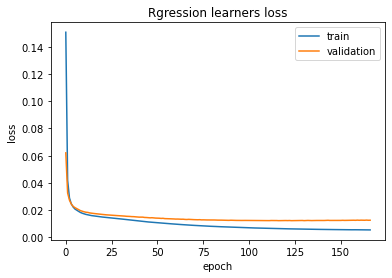

In [11]:
print(historyG.history.keys())

import matplotlib.pyplot as plt

plt.plot(historyG.history['loss'])
plt.plot(historyG.history['val_loss'])
plt.title('Rgression learners loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
#dataset for classifier trainig
X_classifier=X_dem[1500:3000,0:]
y_classifier_bus=y_bus[1500:3000,0:]
y_classifier_branch=y_branch[1500:3000,0:]
print(X_classifier.shape)
print(y_classifier_bus.shape)
print(y_classifier_branch.shape)

(1500, 2708)
(1500, 1354)
(1500, 1991)


In [13]:
# Generation prediction
X_classifier_dem=np.copy(X_classifier)
X_classifier_dem=X_classifier_dem[:,load_index[0,0:]]  

X_classifier_dem=xscaler.transform(X_classifier_dem)# scaling demand
y_predG=modelG.predict(X_classifier_dem)
y_predG=yscaler.inverse_transform(y_predG)# descaling gen output
X_classifier_dem=xscaler.inverse_transform(X_classifier_dem)# descaling demand

print(X_classifier.shape)
print(X_classifier_dem.shape)

(1500, 2708)
(1500, 1332)


In [14]:
#converting (ng*1) to (nb*1) matrix
#As pyhton indexing start from zero
Gen_index=Gen_index-1

y_predG_temp=np.zeros([np.size(X_classifier,0),nb*2], dtype = int)

for s in range(np.size(X_classifier,0)):
    for i in range(ng):    
        y_predG_temp[s,Gen_index[i]]=y_predG[s,i]
        y_predG_temp[s,Gen_index[i]+nb]=y_predG[s,i+ng] #ng=10

In [15]:
#forming net injection vectors
X_NI=y_predG_temp-X_classifier
#scaling net injection vectors
NIscaler = MinMaxScaler()
X_NI=NIscaler.fit_transform(X_NI)

X_NI.shape

(1500, 2708)

In [16]:
#Train test split of model
from sklearn.model_selection import train_test_split
# model for voltage
X_trainV,X_testV,y_trainV,y_testV = train_test_split(X_NI,y_classifier_bus,test_size = 0.001,random_state = 0,shuffle=True)
# model for branch
X_trainB,X_testB,y_trainB,y_testB = train_test_split(X_NI,y_classifier_branch,test_size = 0.001,random_state = 0,shuffle=True)

In [17]:
import tensorflow.keras.backend as K

def f2(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return K.mean(f2)

def f2_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return 1 - K.mean(f2)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=100, 
    min_delta=0.00001, 
    mode='min',
    verbose=1
)

In [19]:
#bus slassifier model
modelV = Sequential()
modelV.add(Dense(256, input_dim=np.size(X_NI,1), activation='relu'))
modelV.add(Dense(nb, activation='sigmoid'))
modelV.compile(loss=f2_loss, optimizer='adam', metrics=[f2])

#branch slassifier model
modelB = Sequential()
modelB.add(Dense(256, input_dim=np.size(X_NI,1), activation='relu'))
modelB.add(Dense(nl, activation='sigmoid'))
modelB.compile(loss=f2_loss, optimizer='adam', metrics=[f2])

In [20]:
historyV = modelV.fit(X_trainV, y_trainV, epochs=1000, batch_size=100,verbose=0,validation_split=0.2,callbacks=[custom_early_stopping])
historyB = modelB.fit(X_trainB, y_trainB, epochs=1000, batch_size=100,verbose=0,validation_split=0.2,callbacks=[custom_early_stopping])

Epoch 00102: early stopping
Epoch 00101: early stopping


dict_keys(['loss', 'f2', 'val_loss', 'val_f2'])


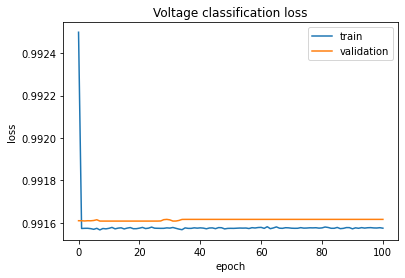

In [21]:
print(historyV.history.keys())

import matplotlib.pyplot as plt

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
#plt.plot(historyB.history['accuracy'])
plt.title('Voltage classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'accuracy'], loc='upper right')
plt.show()

dict_keys(['loss', 'f2', 'val_loss', 'val_f2'])


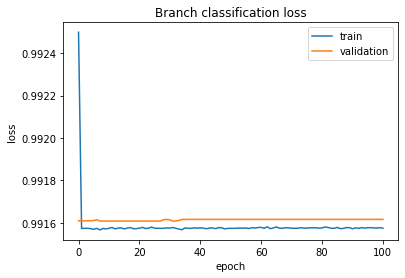

In [22]:
print(historyB.history.keys())

import matplotlib.pyplot as plt

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
#plt.plot(historyB.history['accuracy'])
plt.title('Branch classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'accuracy'], loc='upper right')
plt.show()

In [23]:
#Final testing
X_test_dem=X_dem[3000:,0:]
y_test_gen =y_gen[3000:,0:]
y_test_bus=y_bus[3000:,0:]
y_test_branch=y_branch[3000:,0:]
print(X_test_dem.shape)
print(y_test_gen.shape)
print(y_test_bus.shape)
print(y_test_branch.shape)

(1200, 2708)
(1200, 520)
(1200, 1354)
(1200, 1991)


In [24]:
#Filtering zeros from demand
X_test_dem_temp=X_test_dem[:,load_index[0,0:]]

print(X_test_dem.shape)
print(X_test_dem_temp.shape)

# Generation prediction 
X_test_dem_temp=xscaler.transform(X_test_dem_temp)#scaling demand
y_predG=modelG.predict(X_test_dem_temp)
y_predG=yscaler.inverse_transform(y_predG)#descaling gen output
X_test_dem_temp=xscaler.inverse_transform(X_test_dem_temp)#descaling demand

#converting (ng*1) to (nb*1) matrix
y_predG_temp=np.zeros([np.size(X_test_dem,0),nb*2], dtype = int)
for s in range(np.size(X_test_dem,0)):
    for i in range(ng):    
        y_predG_temp[s,Gen_index[i]]=y_predG[s,i]
        y_predG_temp[s,Gen_index[i]+nb]=y_predG[s,i+ng] 

#forming net injection vectors
X_NI_test=y_predG_temp-X_test_dem
X_NI_test=NIscaler.fit_transform(X_NI_test)#scaling net injection

# bus and branch prediction 
y_predV=modelV.predict(X_NI_test)
y_predB=modelB.predict(X_NI_test)

(1200, 2708)
(1200, 1332)


In [25]:
# testing the trained regressor
import math
from sklearn.metrics import mean_squared_error

RMSE=[]
for x in range(np.size(X_test_dem,0)): 
    MSE=mean_squared_error(y_test_gen[x,:], y_predG[x,:])
    RMSE.append(math.sqrt(MSE))
    
mean_RMSE=sum(RMSE)/len(RMSE)
print(mean_RMSE)

23.323976871238045


In [26]:
#testing the trained voltage classifier
from sklearn.metrics import confusion_matrix

y_testV=np.reshape(y_test_bus,np.size(X_test_dem,0)*nb)
y_predV=np.reshape(y_predV,np.size(X_test_dem,0)*nb)

y_predV1=np.copy(y_predV)

y_predV1[y_predV1 >= 0.99] = 1
y_predV1[y_predV1 < 0.99] = 0

CM=confusion_matrix(y_testV, y_predV1)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

s=np.size(X_test_dem,0)# no of test scenario
c=s*nb*2 #total constraints is double for upper and lower limit
TN=c-(TP+FP+FN)
CM[0][0]=TN
print(CM)

FNP=(FN)/(TP+TN+FP+FN)
FPP=(FP)/(TP+TN+FP+FN)
TNP=(TN)/(TP+TN+FP+FN)
TPP=(TP)/(TP+TN+FP+FN)

NPV = TN/(TN+FN)
PPV = TP/(TP+FP)# Precision
TPR = TP/(TP+FN)# Sensitivity, recall 
TNR = TN/(TN+FP)# Specificity 

ACC = (TP+TN)/(TP+FP+FN+TN)

print(FNP, FPP, TNP, TPP, NPV, PPV, TPR, TNR, ACC)

[[1557549   39280]
 [    588   27383]]
0.00018094534711964548 0.0120876415558838 0.9793048375184638 0.008426575578532743 0.9998152649581189 0.410767592217572 0.9789782274498587 0.9878074104746387 0.9877314130969965


In [27]:
#testing the trained branch classifier
y_testB=np.reshape(y_test_branch,np.size(X_test_dem,0)*nl)
y_predB=np.reshape(y_predB,np.size(X_test_dem,0)*nl)

y_predB1=np.copy(y_predB)

y_predB1[y_predB1 >= 0.99] = 1
y_predB1[y_predB1 < 0.99] = 0

CM=confusion_matrix(y_testB, y_predB1)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

c=s*nb*2 
TN=c-(TP+FP+FN)
CM[0][0]=TN
print(CM)

FNP=(FN)/(TP+TN+FP+FN)
FPP=(FP)/(TP+TN+FP+FN)
TNP=(TN)/(TP+TN+FP+FN)
TPP=(TP)/(TP+TN+FP+FN)

NPV = TN/(TN+FN)
PPV = TP/(TP+FP)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 

ACC = (TP+TN)/(TP+FP+FN+TN)

print(FNP, FPP, TNP, TPP, NPV, PPV, TPR, TNR, ACC)

[[2271862  100024]
 [      0   17314]]
0.0 0.030780403741999016 0.963891555883801 0.005328040374199901 1.0 0.1475566312703472 1.0 0.9690547185490392 0.969219596258001
